# Dev Set Supervised Modeling 

Produce models and predictions for use as labeling functions.  The process for this is:

- **dev** predictions
    1. K fold split on **dev** candidates (with fairly large K)
    2. Train a model on each fold using **val** split for validation and out-of-sample fold as **test**
- **train** predictions
    1. Train on all **dev** with **val** for validation
    2. Apply to all **train** candidates
- Concatenate predictions for both sets, stored in large dict keyed by id, expose in LFs

In [1]:
import pandas as pd
import numpy as np
import tqdm
import snorkel
import os
import os.path as osp
import plotnine as pn
from snorkel import SnorkelSession
from snorkel.models import Candidate
from tcre.env import *
from tcre.supervision import *
from tcre.exec.v1 import cli_client
session = SnorkelSession()
classes = get_candidate_classes()

In [3]:
output_dir = osp.join(RESULTS_DATA_DIR, 'training-dev', 'run2')
search_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run2')
n_cv_splits = 10
output_dir, search_dir, n_cv_splits

('/lab/data/results/training-dev/run2',
 '/lab/data/results/gridsearch-dev/run2',
 10)

In [4]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

In [5]:
folds = list(map(lambda v: f'{v:03d}', range(n_cv_splits)))
folds

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']

## Generate Splits

In [6]:
def to_df(cands):
    return pd.DataFrame([
        dict(id=c.id, type=c.type, label=c.gold_labels[0].value if c.gold_labels else -1)
        for c in cands
    ])

def get_all_ids(split):
    return to_df(session.query(Candidate).filter(Candidate.split == split).all())\
        .groupby('type')['id'].unique().apply(list)

In [7]:
SPLIT_MAP

{0: 'train', 1: 'dev', 2: 'infer', 3: 'test', 4: 'val'}

In [8]:
# Load all ids for each split (may take a few minutes)
ids = {
    SPLIT_MAP[k]: get_all_ids(k)
    for k in [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN]
}

df_split_ct = pd.DataFrame([
    dict(split=split, task=task, nids=len(ids[split][task]))
    for split in ids.keys()
    for task in ids[split].keys()
])
df_split_ct

,nids,split,task
0,673,dev,inducing_cytokine
1,410,dev,inducing_transcription_factor
2,673,dev,secreted_cytokine
3,97,val,inducing_cytokine
4,117,val,inducing_transcription_factor
5,98,val,secreted_cytokine
6,100,test,inducing_cytokine
7,100,test,inducing_transcription_factor
8,100,test,secreted_cytokine
9,48656,train,inducing_cytokine


In [9]:
# Load dev candidates and labels for stratification
df = to_df(session.query(Candidate).filter(Candidate.split.in_([SPLIT_DEV])).all())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 3 columns):
id       1756 non-null int64
label    1756 non-null int64
type     1756 non-null object
dtypes: int64(2), object(1)
memory usage: 41.2+ KB


In [10]:
df.groupby(['type', 'label']).size().unstack()

label,-1,1
type,,
inducing_cytokine,540,133
inducing_transcription_factor,324,86
secreted_cytokine,592,81


In [11]:
# Build splits with larger fold partition of dev set as training data and held-out
# portion as the prediction target (with validation and test as usual)
from sklearn.model_selection import StratifiedKFold

def get_split(k, g, val_ids, test_ids):
    cv = StratifiedKFold(n_splits=n_cv_splits, random_state=TCRE_SEED)
    for train, test in cv.split(g['id'].values.reshape((-1, 1)), g['label']):
        yield pd.Series({
            'train': list(g['id'].iloc[train].values), 
            'predict': list(g['id'].iloc[test].values), 
            'val': list(val_ids[k]),
            'test': list(test_ids[k])
        })

splits = {}
for task in tasks:
    g = df[df['type'] == task]
    assert len(g) > 0, f'No candidates found for task {task}'
    splits[task] = []
    for split in get_split(task, g, ids['val'], ids['test']):
        splits[task].append(split)

In [12]:
splits.keys()

dict_keys(['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor'])

In [13]:
# Show number of ids to be written in splits files (by fold and task)
pd.DataFrame([
    {**dict(task=k, fold=i), **fold.apply(len).to_dict()}
    for k in splits.keys()
    for i, fold in enumerate(splits[k])
])

,fold,predict,task,test,train,val
0,0,68,inducing_cytokine,100,605,97
1,1,68,inducing_cytokine,100,605,97
2,2,68,inducing_cytokine,100,605,97
3,3,67,inducing_cytokine,100,606,97
4,4,67,inducing_cytokine,100,606,97
5,5,67,inducing_cytokine,100,606,97
6,6,67,inducing_cytokine,100,606,97
7,7,67,inducing_cytokine,100,606,97
8,8,67,inducing_cytokine,100,606,97
9,9,67,inducing_cytokine,100,606,97


In [14]:
# Write split arrays to individual files for each fold
for task, split in splits.items():
    for i, fold in enumerate(split):
        split_file = osp.join(output_dir, 'splits', f'dev_{task}_fold_{i:03d}.json')
        if not osp.exists(osp.dirname(split_file)):
            os.makedirs(osp.dirname(split_file))
        fold.to_json(split_file, orient='index')
print(f"All fold splits written to {osp.join(output_dir, 'splits')}")

All fold splits written to /lab/data/results/training-dev/run2/splits


In [15]:
# Finally, write a split file for each task across the entire dev set
# with the train partition as the prediction target
for task in splits.keys():
    split_file = osp.join(output_dir, 'splits', f'dev_{task}_fold_all.json')
    split_data = pd.Series({
        'train': ids['dev'][task],
        'val': ids['val'][task],
        'test': ids['test'][task],
        'predict': ids['train'][task]
    })
    split_data.to_json(split_file, orient='index')
print(f"Complete splits written to {osp.join(output_dir, 'splits')}")

Complete splits written to /lab/data/results/training-dev/run2/splits


## Training

Load model configs from grid search results:

In [19]:
dftm = pd.read_json(osp.join(search_dir, 'top_model_configurations.json'))
dftm = dftm[dftm['rank'] <= 2] #  Choose top 2 models 
dftm

,param:marker_list,param:use_secondary,param:use_swaps,param:use_positions,param:wrd_embedding_type,param:model_size,param:weight_decay,param:learning_rate,param:dropout,param:cell_type,param:bidirectional,score,task,iteration,rank
0,doub_01,False,True,True,w2v_frozen,XXXXL,0.0000,0.005,0.75,LSTM,False,0.571429,inducing_cytokine,44,1
1,doub_01,False,True,True,w2v_trained,XXXL,0.0010,0.005,0.50,LSTM,False,0.533333,inducing_cytokine,29,2
3,doub_01,True,True,True,w2v_trained,XXXL,0.0000,0.050,0.75,LSTM,False,0.488889,inducing_transcription_factor,68,1
4,doub_01,True,True,True,w2v_trained,XXXL,0.0000,0.010,0.25,LSTM,False,0.478261,inducing_transcription_factor,67,2
6,doub_01,False,True,True,w2v_trained,XXL,0.0000,0.010,0.25,LSTM,False,0.424242,secreted_cytokine,49,1
7,doub_01,False,True,True,w2v_trained,XXL,0.0001,0.005,0.75,LSTM,False,0.400000,secreted_cytokine,91,2


Train all models and create predictions for each:

In [29]:
cfgs = dftm.set_index(['task', 'rank']).filter(regex='param:').rename(columns=lambda c: c.replace('param:', ''))
cfgs

marker_list  use_secondary  use_swaps  \
task                          rank                                         
inducing_cytokine             1        doub_01          False       True   
                              2        doub_01          False       True   
inducing_transcription_factor 1        doub_01           True       True   
                              2        doub_01           True       True   
secreted_cytokine             1        doub_01          False       True   
                              2        doub_01          False       True   

                                    use_positions wrd_embedding_type  \
task                          rank                                     
inducing_cytokine             1              True         w2v_frozen   
                              2              True        w2v_trained   
inducing_transcription_factor 1              True        w2v_trained   
                              2              True        w2v_trained   
secreted_cytokine             1              True        w2v_trained   
                              2              True        w2v_trained   

                                   model_size  weight_decay  learning_rate  \
task                          rank                                           
inducing_cytokine             1         XXXXL        0.0000          0.005   
                              2          XXXL        0.0010          0.005   
inducing_transcription_factor 1          XXXL        0.0000          0.050   
                              2          XXXL        0.0000          0.010   
secreted_cytokine             1           XXL        0.0000          0.010   
                              2           XXL        0.0001          0.005   

                                    dropout cell_type  bidirectional  
task                          rank                                    
inducing_cytokine             1        0.75      LSTM          False  
                              2        0.50      LSTM          False  
inducing_transcription_factor 1        0.75      LSTM          False  
                              2        0.25      LSTM          False  
secreted_cytokine             1        0.25      LSTM          False  
                              2        0.75      LSTM          False

In [26]:
# NOTE: rebalancing done during training, not in split creation
client = cli_client.get_default_client(client_args=dict(train_args=dict(balance=.5)))

In [44]:
CMD_FORMAT = "{cmd} > {log_file} 2>&1"

def run_predictions(folds, tasks, cfgs, dry_run=False):
    df = []
    if not dry_run:
        pbar = tqdm.tqdm(total=len(folds) * len(cfgs.loc[tasks]))
    for task in tasks:
        for fold in folds:
            tcfgs = cfgs.loc[task].to_dict(orient='records')
            for i, cfg in list(enumerate(tcfgs)):
                splits_file = osp.join(output_dir, 'splits', f'dev_{task}_fold_{fold}.json')
                model_dir = osp.join(output_dir, 'models', f'dev_{task}_fold_{fold}_cfg_{i:03d}')
                train_log_file = osp.join(model_dir, 'train_log.txt')
                predict_log_file = osp.join(model_dir, 'predict_log.txt')
                data_dir = osp.join(model_dir, 'data')
                predictions_file = osp.join(data_dir, 'predictions.json')

                if not dry_run:
                    pbar.set_description(f'Processing task={task}, fold={fold}, config={i}')
                    if not osp.exists(model_dir):
                        os.makedirs(model_dir)

                    cli_args = dict(relation_class=task, device='"cuda:1"', output_dir=data_dir)
                    cmd = client.cmd(
                        cli=cli_args,
                        train={**cfg, **dict(use_checkpoints=True, splits_file=splits_file)}
                    )
                    cmd = CMD_FORMAT.format(cmd=cmd, log_file=train_log_file)
                    client.execute(cmd)

                    cmd = client.cmd(
                        cli=cli_args,
                        predict=dict(splits_file=splits_file)
                    )
                    cmd = CMD_FORMAT.format(cmd=cmd, log_file=predict_log_file)
                    client.execute(cmd)
                    pbar.update(1)
                
                df.append(dict(task=task, fold=fold, cfg=i, predictions_file=predictions_file))
    return pd.DataFrame(df)

In [46]:
df_pred = run_predictions(folds + ['all'], tasks, cfgs)

In [30]:
# dfh = pd.read_json('/lab/data/results/training-dev/run1/models/dev_secreted_cytokine_fold_000_cfg_000/data/history.json')
# dfh.set_index(['epoch', 'type'])['f1'].unstack()

In [19]:
# dfp = pd.read_json('/lab/data/results/training-dev/run1/models/dev_secreted_cytokine_fold_all_cfg_000/data/predictions.json')
# dfp.info()

In [18]:
# [
#     (c, c.get_parent().text) for c in 
#     session.query(Candidate).filter(Candidate.id.in_([278083, 60695, 367475, 299321, 19321, 54598, 288078, 331541, 297000, 308685])).all()
# ]

## Performance

In [47]:
df_pred = run_predictions(folds + ['all'], tasks, cfgs, dry_run=True)
df_pred.head()

,cfg,fold,predictions_file,task
0,0,000,/lab/data/results/training-dev/run2/models/dev...,inducing_cytokine
1,1,000,/lab/data/results/training-dev/run2/models/dev...,inducing_cytokine
2,0,001,/lab/data/results/training-dev/run2/models/dev...,inducing_cytokine
3,1,001,/lab/data/results/training-dev/run2/models/dev...,inducing_cytokine
4,0,002,/lab/data/results/training-dev/run2/models/dev...,inducing_cytokine


In [48]:
def get_history(df):
    df = df[df['fold'] == 'all']
    get_history = lambda f: pd.read_json(osp.join(osp.dirname(f), 'history.json'))
    return pd.concat([
        get_history(r['predictions_file']).assign(task=r['task'], cfg=r['cfg'])
        for i, r in df.iterrows()
    ])

def get_performance(df):
    # Pivot to columns like ('test', 'f1')
    df = df.set_index(['task', 'cfg', 'epoch', 'type']).unstack().reset_index()
    
    # Subset to best epoch (per f1 on validation)
    df = df.groupby(['task', 'cfg']).apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)]).reset_index(drop=True)
    
    # Flatten to long form
    df = df.set_index(['task', 'cfg', 'epoch']).stack().rename_axis('metric', axis='columns').stack().rename('value').reset_index()
    assert df.groupby(['task', 'cfg', 'type', 'metric']).size().max() == 1
    return df
    

def plot_performance(df):
    df = df[df['metric'].isin(['precision', 'recall', 'accuracy', 'f1', 'ct', 'balance'])]
    return (
        pn.ggplot(
            df.assign(
                cfg=lambda df: 'model '  + df['cfg'].apply(lambda v: f'{v:02d}'),
                label=lambda df: df.apply(lambda r: ('{:.0f}' if r['metric'] == 'ct' else '{:.2f}').format(r['value']), axis=1)
            ),
            pn.aes(x='type', y='value', fill='cfg', label='label')
        ) + 
        pn.geom_bar(stat='identity', position='dodge', alpha=.5) + 
        pn.geom_text(stat='identity', position=pn.position_dodge(width=1), size=8, va='top') + 
        pn.facet_grid('metric ~ task', scales='free') + 
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 8))
    )

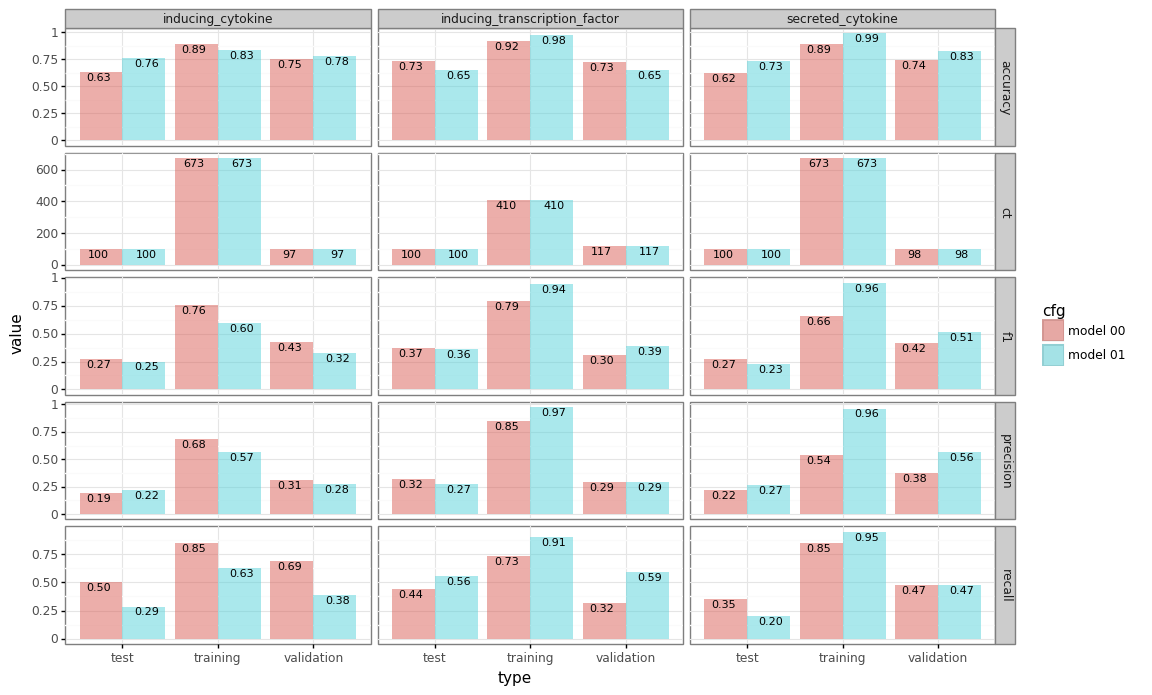

<ggplot: (8775000036991)>

In [52]:
# Performance when trained on all DEV using VAL for validation, TEST for test, and TRAIN for predictions
df_hist = get_history(df_pred)
df_perf = get_performance(df_hist)
plot_performance(df_perf)

In [ ]:
# :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

METRICS = {
    'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 
    'accuracy': accuracy_score, 'ct': lambda y_true, y_pred: len(y_true),
    'balance': lambda y_true, y_pred: (y_true > 0).mean(),
    'TP': lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1,1],
    'FP': lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0,1],
    'FN': lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1,0],
    'TN': lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0,0]
}

def get_oos_preds(df):
    df = df[df['fold'] != 'all']
    return pd.concat([
        pd.read_json(r['predictions_file']).assign(task=r['task'], cfg=r['cfg'], fold=r['fold'])
        for i, r in df.iterrows()
    ])

def get_oos_performance(df):
    assert df['y_true'].isin([0, 1]).all()
    assert df['y_pred'].between(0, 1).all()
    assert df.groupby(['task', 'cfg', 'id']).size().max() == 1
    return df.groupby(['task', 'cfg']).apply(lambda g: pd.Series({k: fn(g['y_true'], g['y_pred'] > .5) for k, fn in METRICS.items()}))

In [77]:
df_oos_pred = get_oos_preds(df_pred)
# 20	83	113	457	
get_oos_performance(df_oos_pred).style.background_gradient()

In [78]:
df_oos_pred.head()

,id,y_true,y_pred,task,cfg,fold
0,30192,0,0.036049,inducing_cytokine,0,000
1,30193,0,0.771132,inducing_cytokine,0,000
10,30200,0,0.389637,inducing_cytokine,0,000
11,30201,0,0.001601,inducing_cytokine,0,000
12,30181,1,0.014142,inducing_cytokine,0,000


In [88]:
df_oos_pred[df_oos_pred['cfg'] == 0].sample(n=10, random_state=2).sort_values('id')#['id'].tolist()

,id,y_true,y_pred,task,cfg,fold
31,30260,0,0.043481,inducing_cytokine,0,001
2,30654,0,0.467924,inducing_cytokine,0,007
11,31005,0,0.577533,secreted_cytokine,0,002
52,31076,0,0.010189,secreted_cytokine,0,003
45,31111,0,0.017612,secreted_cytokine,0,003
41,31306,0,0.306887,secreted_cytokine,0,006
54,31340,1,0.590119,secreted_cytokine,0,007
16,31352,0,0.064763,secreted_cytokine,0,007
15,31548,0,0.008822,inducing_transcription_factor,0,000
30,31625,0,0.006336,inducing_transcription_factor,0,002


## Export

Export a prediction for each candidate and each model:

In [96]:
def collect_predictions(df):
    df = pd.concat([
        pd.read_json(r['predictions_file']).assign(task=r['task'], cfg=r['cfg'])
        for i, r in df.iterrows()
    ])
    
    # Ensure that for each model, there is no more than one prediction per candidate id (across all tasks)
    assert df.groupby('cfg').apply(lambda g: g['id'].value_counts().max()).max() == 1
    
    return df

df_pred_agg = collect_predictions(df_pred)
df_pred_agg.head()

,id,y_true,y_pred,task,cfg
0,30192,0,0.036049,inducing_cytokine,0
1,30193,0,0.771132,inducing_cytokine,0
10,30200,0,0.389637,inducing_cytokine,0
11,30201,0,0.001601,inducing_cytokine,0
12,30181,1,0.014142,inducing_cytokine,0


In [111]:
# Ensure that the total number of predictions produced matches the total number
# of candidates found when generating splits

# Note that the predictions only apply to the DEV and TRAIN splits (others are only used for diagnostics)
n_ids_expected = df_split_ct.pipe(lambda df: df[df['split'].isin(['dev', 'train'])]).groupby('task')['nids'].sum()
n_ids_actual = df_pred_agg.groupby(['task'])['id'].nunique().rename('nids')
assert n_ids_expected.equals(n_ids_actual)
print(n_ids_actual)
print(n_ids_expected)

task
inducing_cytokine                49329
inducing_transcription_factor    23393
secreted_cytokine                49200
Name: nids, dtype: int64
task
inducing_cytokine                49329
inducing_transcription_factor    23393
secreted_cytokine                49200
Name: nids, dtype: int64


In [112]:
path = osp.join(output_dir, 'predictions.csv')
df_pred_agg.to_csv(path, index=False)
path

'/lab/data/results/training-dev/run1/predictions.csv'